In [82]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from keras.layers import Dropout

import tensorflow as tf
print(tf.__version__)
import time, sys
from IPython.display import clear_output

2.3.0


In [192]:
raw_data = pd.read_csv('Infosys.csv')
raw_data = raw_data.dropna()
raw_data = raw_data.drop(['Adj Close'], axis=1)
raw_data

,Date,Open,High,Low,Close,Volume
0,2000-01-10,102.542999,110.746002,94.339798,107.478996,30230400.0
1,2000-01-11,103.125000,107.811996,98.880898,98.880898,15658368.0
2,2000-01-12,93.359398,104.289001,91.921898,102.167999,25993472.0
3,2000-01-13,102.344002,102.726997,93.994904,94.457802,20038400.0
4,2000-01-14,95.695297,96.070297,87.523399,95.128098,16040064.0
...,...,...,...,...,...,...
5190,2020-09-30,1009.000000,1023.950012,1005.000000,1008.250000,8048817.0
5191,2020-10-01,1020.599976,1026.500000,1011.750000,1017.650024,5563358.0
5192,2020-10-05,1018.049988,1054.900024,1018.049988,1048.699951,14212509.0
5193,2020-10-06,1055.000000,1060.000000,1031.349976,1055.750000,9090819.0


In [193]:
n_lag = 5
n_seq = 5
new_data = pd.DataFrame()
for i in range(1,n_lag+1):
    var_name = 'Shifted Close Price ' + str(i)
    raw_data[var_name] = raw_data['Close'].shift(i)
# for i in range(1,n_seq+1):
#     var_name = 'Shifted Close Price ' + str(-i)
#     raw_data[var_name] = raw_data['Close'].shift(-i)
#     raw_data['Shifted Close Price 2'] = raw_data['Close Price'].shift(-2)
#     raw_data['Shifted Close Price 3'] = raw_data['Close Price'].shift(-3)
#     raw_data['Shifted Close Price 4'] = raw_data['Close Price'].shift(-4)
#     raw_data['Shifted Close Price 5'] = raw_data['Close Price'].shift(-5)
raw_data = raw_data.dropna()
raw_data

,Date,Open,High,Low,Close,Volume,Shifted Close Price 1,Shifted Close Price 2,Shifted Close Price 3,Shifted Close Price 4,Shifted Close Price 5
5,2000-01-17,95.312500,100.664001,91.562500,92.741402,18092928.0,95.128098,94.457802,102.167999,98.880898,107.478996
6,2000-01-18,91.716400,95.070297,88.476601,93.247299,20290944.0,92.741402,95.128098,94.457802,102.167999,98.880898
7,2000-01-19,98.015602,100.707001,97.031197,100.702003,19994752.0,93.247299,92.741402,95.128098,94.457802,102.167999
8,2000-01-20,103.125000,105.866997,98.523399,99.586304,19778560.0,100.702003,93.247299,92.741402,95.128098,94.457802
9,2000-01-21,100.780998,106.171997,97.679703,104.845001,20786048.0,99.586304,100.702003,93.247299,92.741402,95.128098
...,...,...,...,...,...,...,...,...,...,...,...
5190,2020-09-30,1009.000000,1023.950012,1005.000000,1008.250000,8048817.0,1009.000000,1010.400024,1011.450012,975.400024,1019.750000
5191,2020-10-01,1020.599976,1026.500000,1011.750000,1017.650024,5563358.0,1008.250000,1009.000000,1010.400024,1011.450012,975.400024
5192,2020-10-05,1018.049988,1054.900024,1018.049988,1048.699951,14212509.0,1017.650024,1008.250000,1009.000000,1010.400024,1011.450012
5193,2020-10-06,1055.000000,1060.000000,1031.349976,1055.750000,9090819.0,1048.699951,1017.650024,1008.250000,1009.000000,1010.400024


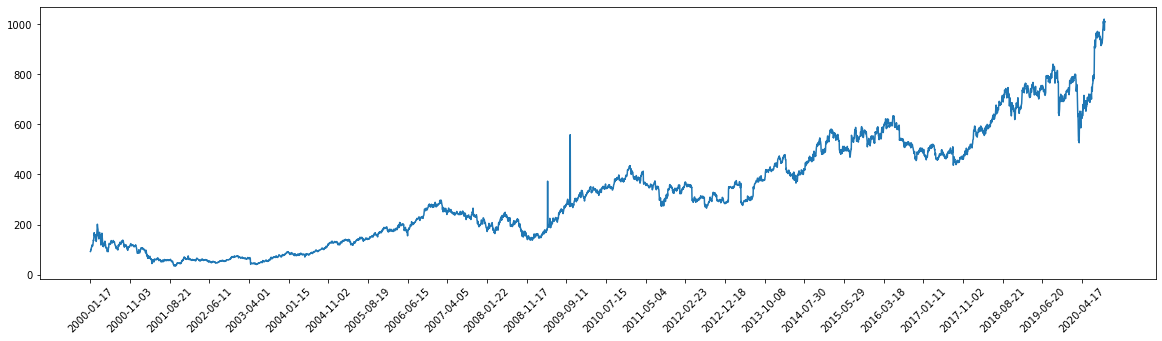

In [188]:
fig, (ax1) = plt.subplots(1,1, figsize=(20,5))
ax1.plot(raw_data['Date'], raw_data['Close'])
ax1.set_xticks(raw_data['Date'][::200])
ax1.set_xticklabels(raw_data['Date'][::200], rotation=45)
plt.show()

In [194]:
# training_columns = ['Open','Volume', 
#                     'Shifted Close Price 1', 'Shifted Close Price 2', 'Shifted Close Price 3',
#                     'Shifted Close Price 4', 'Shifted Close Price 5', 'Shifted Close Price 6',
#                     'Shifted Close Price 7', 'Shifted Close Price 8', 'Shifted Close Price 9',
#                     'Close']
training_set = raw_data.values
training_set.shape

(5121, 11)

In [157]:
training_set[:,-1:]

array([[108.428001],
       [110.230003],
       [115.480003],
       ...,
       [1048.699951],
       [1055.75],
       [1066.550049]], dtype=object)

In [196]:
from sklearn.preprocessing import MinMaxScaler
sc_x = MinMaxScaler(feature_range = (0, 1))
training_set_x_scaled = sc_x.fit_transform(training_set[:,1:11])
sc_y = MinMaxScaler(feature_range = (0, 1))
training_set_y_scaled = sc_y.fit_transform(training_set[:,10:11])
# print(training_set_x_scaled.shape, training_set_y_scaled.shape)


In [144]:
X_train = []
y_train = []
for i in range(5, int(len(training_set_x_scaled))):
    X_train.append(training_set_x_scaled[i-5:i, :])
    y_train.append(training_set_y_scaled[i, :])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(9, 5, 10) (9, 1)


In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [58]:
def forecast_lstm(model, x, n_batch):
    x = x.reshape(1, 5, 10)
    forecast = model.predict(x, batch_size=n_batch)
    return [x for x in forecast[0, :]]

def make_forecast(model, n_batch, X_test, y_test):
    forecasts = list()
    for i in range(len(X_test)):
        x,y = X_test[i], y_test[i]
        forecast = forecast_lstm(model, x , n_batch)
        forecasts.append(forecast)
    return forecasts

In [43]:
n_neurons = 50
n_batch = 1
model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X_train.shape[1], X_train.shape[2]),
               return_sequences=True, activation='relu', recurrent_activation='hard_sigmoid'))
model.add(LSTM(n_neurons, return_sequences=True, activation='relu', 
               recurrent_activation='hard_sigmoid'))
model.add(LSTM(n_neurons, activation='relu', recurrent_activation='hard_sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')

for i in range(10):
    model.fit(X_train, y_train, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
    model.reset_states()

3832/3832 [==============================] - 13s 3ms/step - loss: 0.0015


In [202]:
train_sub_x = training_set_x_scaled[:]
train_sub_y = training_set_y_scaled[:]
# test_sub_x = training_set_x_scaled[4500:]
# test_sub_y = training_set_y_scaled[4500:]


x_train_cnn = train_sub_x.reshape(train_sub_x.shape[0],train_sub_x.shape[1],1)
y_train_cnn = train_sub_y

x_test_cnn = test_sub_x.reshape(test_sub_x.shape[0],test_sub_x.shape[1],1)
y_test_cnn = test_sub_y
    
print(x_train_cnn.shape, x_test_cnn.shape)


(5121, 10, 1) (616, 10, 1)


In [160]:
input_shape = x_train_cnn.shape[1]
output_shape = y_train_cnn.shape[1]

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, input_shape=(input_shape,1), kernel_size=3, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
cnn_model.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=32, activation='relu'))
cnn_model.add(Dense(units=output_shape))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=5,
                                                mode='min')
cnn_model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
            optimizer=tf.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.Accuracy()])
cnn_model.fit(x_train_cnn, y_train_cnn, epochs=10, batch_size=1)

Epoch 1/10
4500/4500 [==============================] - 3s 728us/step - loss: 0.0192 - mean_absolute_error: 0.0192 - accuracy: 0.0000e+00
Epoch 2/10
4500/4500 [==============================] - 3s 759us/step - loss: 0.0154 - mean_absolute_error: 0.0154 - accuracy: 0.0000e+00
Epoch 3/10
4500/4500 [==============================] - 4s 815us/step - loss: 0.0134 - mean_absolute_error: 0.0134 - accuracy: 0.0000e+00
Epoch 4/10
4500/4500 [==============================] - 4s 879us/step - loss: 0.0132 - mean_absolute_error: 0.0132 - accuracy: 0.0000e+00
Epoch 5/10
4500/4500 [==============================] - 3s 754us/step - loss: 0.0122 - mean_absolute_error: 0.0122 - accuracy: 0.0000e+00
Epoch 6/10
4500/4500 [==============================] - 3s 748us/step - loss: 0.0117 - mean_absolute_error: 0.0117 - accuracy: 0.0000e+00
Epoch 7/10
4500/4500 [==============================] - 3s 752us/step - loss: 0.0119 - mean_absolute_error: 0.0119 - accuracy: 0.0000e+00
Epoch 8/10
4500/4500 [============

5121 5         92.741402
6         93.247299
7        100.702003
8         99.586304
9        104.845001
           ...     
5190    1008.250000
5191    1017.650024
5192    1048.699951
5193    1055.750000
5194    1066.550049
Name: Close, Length: 5121, dtype: float64


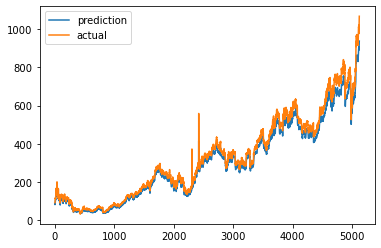

In [204]:
print(len(x_train_cnn), raw_data['Close'])
y_pred = cnn_model.predict(x_train_cnn)
y_pred = sc_y.inverse_transform(y_pred)
y_actual = raw_data['Close'].values

plt.plot(y_pred, label='prediction')
plt.plot(y_actual, label='actual')
plt.legend()

3832


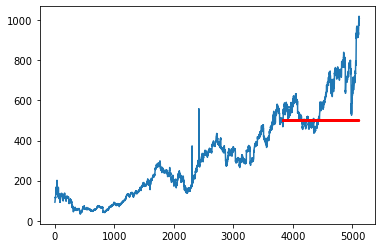

In [70]:
plt.plot(raw_data['Close'].values)
print(len(X_train))
for i in range(len(predicted_stock_price)):
    off_s = len(X_train) + i
    off_e = off_s + len(predicted_stock_price[i])
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = predicted_stock_price[i]
    plt.plot(xaxis, yaxis, color='red')
plt.show()

In [311]:
print(len(X_train), raw_data['Close Price'].values[len(X_train)], predicted_stock_price[0])

367 643.0 [605.98004 613.13544 616.4458  621.5923  625.75696]


In [149]:
raw_data = pd.read_csv('INFY.NS.csv')
raw_data = raw_data.dropna()
raw_data = raw_data.drop(['Date','Symbol','Series','LTP','Turnover\n(in Lakhs)'], axis=1)
raw_data['Volume'] = raw_data['Volume'].str.replace(',', '')
raw_data['Volume'] = raw_data['Volume'].astype(int)
raw_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-10,102.542999,110.746002,94.339798,107.478996,3.551731,30230400.0
1,2000-01-11,103.125000,107.811996,98.880898,98.880898,3.267598,15658368.0
2,2000-01-12,93.359398,104.289001,91.921898,102.167999,3.376225,25993472.0
3,2000-01-13,102.344002,102.726997,93.994904,94.457802,3.121434,20038400.0
4,2000-01-14,95.695297,96.070297,87.523399,95.128098,3.143584,16040064.0
...,...,...,...,...,...,...,...
5190,2020-09-30,1009.000000,1023.950012,1005.000000,1008.250000,1008.250000,8048817.0
5191,2020-10-01,1020.599976,1026.500000,1011.750000,1017.650024,1017.650024,5563358.0
5192,2020-10-05,1018.049988,1054.900024,1018.049988,1048.699951,1048.699951,14212509.0
5193,2020-10-06,1055.000000,1060.000000,1031.349976,1055.750000,1055.750000,9090819.0


In [170]:
from tensorflow import keras
cnn_model.save('cnn_model')
cnn_model = keras.models.load_model('cnn_model')

INFO:tensorflow:Assets written to: cnn_model/assets


In [171]:
import numpy as np
from flask import Flask, render_template,request
import pickle#Initialize the flask App
app = Flask(__name__)
cnn_model = keras.models.load_model('cnn_model')

In [172]:
#default page of our web-app
@app.route('/')
def home():
    return render_template('index.html')

In [175]:
#To use the predict button in our web-app
@app.route('/predict',methods=['POST'])
def predict_x():
    #For rendering results on HTML GUI
    int_features = [float(x) for x in request.form.values()]
    final_features = [np.array(int_features)]
    prediction = model.predict(final_features)
    output = round(prediction[0], 2) 
    return render_template('index.html', prediction_text='CO2    Emission of the vehicle is :{}'.format(output))

In [176]:
app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with inotify reloader


SystemExit: 1

/home/akshat/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


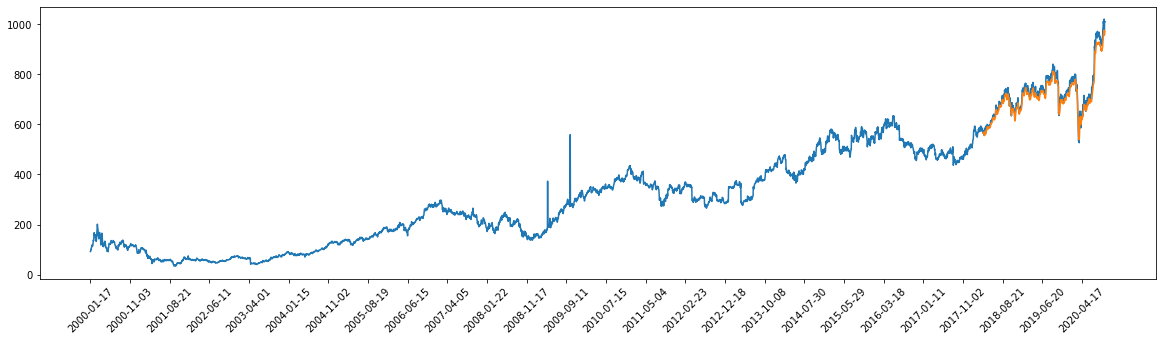

In [189]:
import numpy, matplotlib
fig, (ax1) = plt.subplots(1,1, figsize=(20,5))
df1 = pd.DataFrame(raw_data['Close'].values, index=raw_data['Date'], columns=['events'])
df2 = pd.DataFrame(y_pred, index=raw_data['Date'].values[4500:], columns=['events'])
ax1.plot(df1.index, df1.events)
ax1.plot(df2.index, df2.events)
ax1.set_xticks(raw_data['Date'][::200])
ax1.set_xticklabels(raw_data['Date'][::200], rotation=45)
plt.show()